# Assignment #3 - Reinforcement Learning

### <font color="red"> DUE: Oct 25 (Thursday) 11:00 pm </font>  

<font color="blue"> Benjamin Daniel Poole </font>

# I. Overview

The goal of this assignment is to use the Q-learning or SARSA algorithms to find a path through a maze to a goal node. The core idea of these algorithms is to repeatedly update the Q-values of the environment until the agent can optimally navigate to the goal node. Alongside of this, I want to see how changing different parameters affects the agents learning.

# II. Problems 

## A. Maze Problem (Practice)

The maze problem works by defining some maze-like environment where an agent must learn to reach some goal within said maze. In the GridWrold maze problem the maze is represented by a 2d array where every node is filled with the letters *O*, *H* and *G*. The letter *O* represents the locations the agent can move to. The letter *H* represents an impassable location, a location the agent can't move to. The letter *G* represents the goal location, where the agent wants to end up at. Overtime the agent should try different paths and learn from its mistake until it finally develops the best path to the goal node *G*. <br>

The environment dynamics are relatively simple with two major rules. First, if the agent moves off the grid then it receives a negative reward and is moved back to its previous location. Second, if the agent moves into an obstacle it receives a negative reward and is moved back to its previous location.

In [1]:
import collections
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

### Sample Grid Environment File

Simple text file with three characters, 'O', 'H', and 'G'.
- 'O': open space
- 'H': Wall or obstacles
- 'G': Goal location 

In [2]:
%%bash 
cat grid.txt

OOOHOOOOO
OOOHOOHOO
OOOOOOHOO
OOOOHHHOO
OOHOOOOOH
OOHOOOGOO
OOOOOOOOO

### GridWorld Class


In [3]:
# maze example

class GridWorld:
    """ Grid World environment
            there are four actions (left, right, up, and down) to move an agent
            In a grid, if it reaches a goal, it get 30 points of reward.
            If it falls in a hole or moves out of the grid world, it gets -5.
            Each step costs -1 point. 

        to test GridWorld, run the following sample codes:

            env = GridWorld('grid.txt')

            env.print_map()
            print [2,3], env.check_state([2,3])
            print [0,0], env.check_state([0,0])
            print [3,4], env.check_state([3,4])
            print [10,3], env.check_state([10,3])

            env.init([0,0])
            print env.next(1)  # right
            print env.next(3)  # down
            print env.next(0)  # left
            print env.next(2)  # up
            print env.next(2)  # up

        Parameters
        ==========
        _map        ndarray
                    string array read from a file input
        _size       1d array
                    the size of _map in ndarray
        goal_pos    tuple
                    the index for the goal location
        _actions    list
                    list of actions for 4 actions
        _s          1d array
                    current state
    """
    def __init__(self, fn):
        # read a map from a file
        self._map = self.read_map(fn)
        self._size = np.asarray(self._map.shape)
        self.goal_pos = np.where(self._map == 'G')

        # definition of actions (left, right, up, and down repectively)
        self._actions = [[0, -1], [0, 1], [-1, 0], [1, 0]]
        self._s = None

    def get_cur_state(self):
        return self._s

    def get_size(self):
        return self._size

    def read_map(self, fn):
        grid = []
        with open(fn) as f:
            for line in f:
               grid.append(list(line.strip()))
        return np.asarray(grid)

    def print_map(self):
        print( self._map )

    def check_state(self, s):
        if isinstance(s, collections.Iterable) and len(s) == 2:
            if s[0] < 0 or s[1] < 0 or\
               s[0] >= self._size[0] or s[1] >= self._size[1]:
               return 'N'
            return self._map[tuple(s)].upper()
        else:
            return 'F'  # wrong input

    def init(self, state=None):
        if state is None:
            s = [0, 0]
        else:
            s = state

        if self.check_state(s) == 'O':
            self._s = np.asarray(state)
        else:
            raise ValueError("Invalid state for init")

    def next(self, a):
        #print("Current State:", self._s, a)
        #print("Action code:", self._actions[a])
        #print("Calc next state:", self._s + self._actions[a])
        s1 = self._s + self._actions[a]
       # print("Next State:", s1)
        # state transition
        curr = self.check_state(s1)
        
        if curr == 'H' or curr == 'N':
            return -5
        elif curr == 'F':
            warnings.warn("invalid state " + str(s1))
            return -5
        elif curr == 'G':
            self._s = s1
            return 30
        else:
            self._s = s1
            return -1
        
    def is_goal(self):
        return self.check_state(self._s) == 'G'
            
    def get_actions(self):
        return self._actions

In [4]:
env = GridWorld("grid.txt")
env.print_map()
print("Map Shape:", env.get_size())

[['O' 'O' 'O' 'H' 'O' 'O' 'O' 'O' 'O']
 ['O' 'O' 'O' 'H' 'O' 'O' 'H' 'O' 'O']
 ['O' 'O' 'O' 'O' 'O' 'O' 'H' 'O' 'O']
 ['O' 'O' 'O' 'O' 'H' 'H' 'H' 'O' 'O']
 ['O' 'O' 'H' 'O' 'O' 'O' 'O' 'O' 'H']
 ['O' 'O' 'H' 'O' 'O' 'O' 'G' 'O' 'O']
 ['O' 'O' 'O' 'O' 'O' 'O' 'O' 'O' 'O']]
Map Shape: [7 9]


In [5]:
# top-left to (0,0)
def coord_convert(s, sz):
    return [s[1], sz[0]-s[0]-1]

# III. Methods


## RLAgent for Maze

Below is the code for the RLAgent class that allows an agent to navigate the custom made grid world! The RLAgent class contains 3 mains functions (not including __init__). <br>

- The first function is the train() function. This function is where the agent utilizes a host of parameters and the famous SARSA or Q-learning algorithms. I will be utilizing Q-learning due to its off-policy behavior but let me explain how both SARSA and Q-learning work. Both algorithms work by a taking a one-step look ahead which finds the next state-action value and utilizes this next state-action value as a target. Therefore, both algorithms utilize TD error (reward + next state-action value - current state-action value). The main difference is that Q-learning doesn’t base its one-step look ahead on the policy, it picks the maximum state-action value as the target (off-policy = s_t+1, a). On the other hand, SARSA bases its one-step look ahead on the current policy and picks the next state-action value in the policy as the target (on-policy = s_t+1, a_t+1). Both of these algorithms sever as updates to the Q-table which is the main functionality of the train() function, Q-table updates are equivalent to learning. Below are the update functions for SARSA and Q-learning. Since Q-table updates are the main focus of the train() function the rest of the code in the train() function focuses on grabbing the current state and action while also utilizing epsilon greedy to main to exploration vs exploitation when picking the next state and action.

    - The answer to the question bellow, "Why is this zero?", is a rather simple. The next state and action after the goal node is 0 because there are no more next states or actions after the goal. Therefore, we set the next state and action values to 0 to account for the episode ending and no further reward can be earned.
    
    - As I previously mentioned I decided to go with Q-learning due to its off-policy learning. From what I have read and seen Q-learning seems to provide a deeper robustness to learning and is commonly used in today’s research, therefore, I chose Q-learning.
    
**SARSA Update**
$$
    Q(s_t, a_t) \leftarrow Q(s_t, a_t) + \alpha ( R_{t+1} + \gamma Q(s_{t+1}, a_{t+1}) - Q(s_t, a_t)) 
$$

**Q-Learning Update**
$$
    Q(s_t, a_t) \leftarrow Q(s_t, a_t) + \alpha ( R_{t+1} + \gamma \max_a Q(s_{t+1}, a) - Q(s_t, a_t)) 
$$

- The second function is the epsilon_greed() function, mentioned above. The epsilon_greed() function works by randomly taking actions based on the parameter epsilon. If epsilon is equal to .2 then there is a 20% chance for a random action to be selected. Otherwise the algorithm choses a greedy action, defined by taking the maximal Q-value. Below is how the epsilon_greed() function selects its actions greedly.

$$
a^* = \arg \max_a Q(S_t, a)
$$

- Lastly, we have the test() function. This function sole purpose is to exploit the learned policy. It operates almost exactly like the train() function but without the Q-table updates and random actions. In order to exploit the current policy the function simply takes the maximal Q-value for every state-action pair.

In [1]:
class RLAgent: 
    """
        Reinforcement Learning Agent Model for training/testing
        with Tabular function approximation
        
    """
    
    def __init__(self, evn):
        self.env = env
        self.size = env.get_size()
        self.n_a = len(env.get_actions())
        # self.Q table including the surrounding border
        self.Q = np.zeros((self.size[0], self.size[1], self.n_a))
        
    def epsilon_greed(self, epsilon, s):
        if np.random.rand() < epsilon:
            return np.random.randint(self.n_a)
        return np.argmax(self.Q[s[0],s[1],:])
    
    def train(self, start, **params):
        
        # parameters
        gamma = params.pop('gamma', 0.99)
        alpha = params.pop('alpha', 0.1)
        epsilon= params.pop('epsilon', 0.1)
        maxiter= params.pop('maxiter', 1000) 
        maxstep= params.pop('maxstep', 1000)
        
        # init self.Q matrix
        self.Q[...] = 0
        self.Q[self.env._map == 'H'] = -np.inf
        # online train
        # rewards and step trace
        rtrace = []
        steps = []
        for j in range(maxiter):

            env.init(start)
            s = env.get_cur_state()

            rewards = []
            trace = np.array(coord_convert(s, self.size))
            
            # run simulation for max number of steps 
            for step in range(maxstep):
                # selection an action
                a = self.epsilon_greed(epsilon, s) # on-policy with e-greedy
                r = env.next(a)
                s1 = env.get_cur_state()
                a1 = np.argmax(self.Q[s1[0],s1[1],:]) # off-policy argmax
                               
                rewards.append(r)
                trace = np.vstack((trace, coord_convert(s1, self.size)))
                
                # TODO: FINISH SARSA/Q-learning Rule here
                # update self.Q table 
                self.Q[s[0],s[1], a] += alpha * (r + gamma * self.Q[s1[0],s1[1], a1] - self.Q[s[0],s[1], a])
                
                if env.is_goal(): # reached the goal
                    # TODO: Why is this zero? Describe this in your code explanation.
                    self.Q[s1[0], s1[1], a1] = 0
                    break

                s = s1

            rtrace.append(np.sum(rewards))
            steps.append(step+1)
        return rtrace, steps, trace # last trace of trajectory

    def test(self, start, maxstep=1000):
        # TODO: Add your test routine that exmines learned policy
        #      Using the learned policy, generate the trajectory of 
        env.init(start)
        s = env.get_cur_state()
        # selection an action
        a = np.argmax(self.Q[s[0],s[1], :])

        rewards = []
        trace = np.array(coord_convert(s, self.size))
        
        for step in range(maxstep): 
            r = env.next(a)
            s1 = env.get_cur_state()
            a1 = np.argmax(self.Q[s1[0],s1[1],:])

            rewards.append(r)
            trace = np.vstack((trace, coord_convert(s1, self.size)))

            if env.is_goal(): # reached the goal
                self.Q[s1[0], s1[1], a1] = 0
                break

            s = s1
            a = a1

            #trace.append(np.sum(rewards))
            #teps.append(step+1)
        return trace            

# IV - Results

- Below I will describe my results and my changes to the following parameters: $\gamma$, $\alpha$, and $\epsilon$. 
- Each parameter change comes with a host of graphs to visualize how the agent is chaning.

### Utility functions for Plotting

In [10]:
### Plotting tools 

def plot_trace(agent, start, trace, title="test trajectory"):
    plt.plot(trace[:, 0], trace[:, 1], "ko-")
    plt.text(env.goal_pos[1], agent.size[0]-env.goal_pos[0]-1, 'G')
    plt.text(start[1], agent.size[0]-start[0]-1, 'S')
    plt.xlim([0, agent.size[1]])
    plt.ylim([0, agent.size[0]])
    

def plot_train(agent, rtrace, steps, trace, start):

    fig = plt.figure(figsize=(10,8))
    ax = fig.add_subplot(221)
    # TODO: plot rewards 
    ax.plot(rtrace, '-b')
    
    plt.ylabel("sum of rewards")

    ax1 = fig.add_subplot(222)
    # TODO: plot steps
    ax1.plot(steps, '-')
    
    plt.ylabel("# steps")

    # contour plot for agent.Q
    ax2 = fig.add_subplot(223)
    xs = range(agent.size[1])
    ys = range(agent.size[0])
    maxQ = np.max(agent.Q, axis=2)
    h_b = (maxQ==-np.inf)
    maxQ[h_b] = 0
    maxQ[h_b] = np.min(maxQ) - 100
    cs = plt.contourf(xs, ys[::-1], maxQ)
    plt.colorbar(cs)
    plt.text(env.goal_pos[1], agent.size[0]-env.goal_pos[0]-1, 'G')
    plt.text(start[1], agent.size[0]-start[0]-1, 'S')
    plt.ylabel("max agent.Q")

    # plot traces
    ax3 = fig.add_subplot(224)
    plot_trace(agent, start, trace, "trace of the last episode")

    plt.plot()

### Training and Testing with GridWorld

Here we have our basic parameters for reinforcement learning. My goal for the following parameter changes is to maximize the explored area so when we start at further way starting position like [1,8], the agent will still be able to find the goal. The current issue with the below parameters is that they don’t seem to allow for enough exploring to, only just enough to find the goal but not enough to explore the whole environment. <br>

It should be noted that these current parameters are very stable and work excellent for static starting positions. Rarely though will the agent be able to find the goal when starting from a drastically different starting position. As we can see if we slightly move the starting position from [0,0] to [0,2] the agent can easily find the goal.

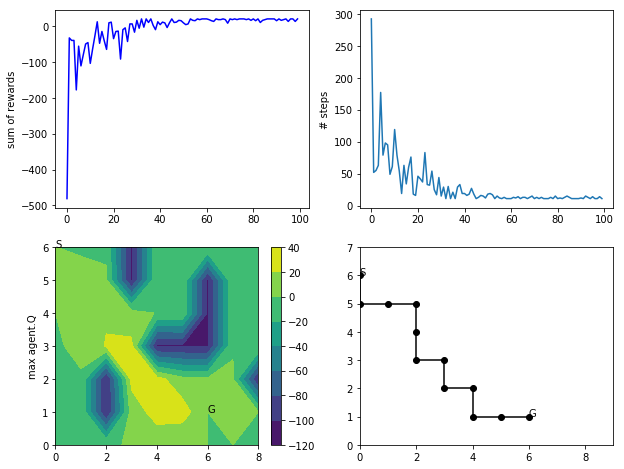

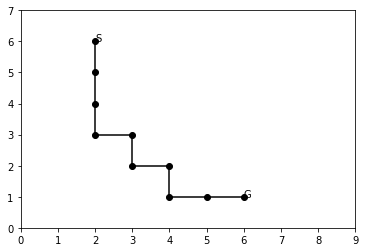

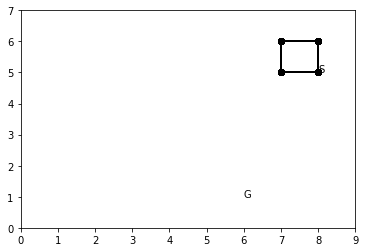

In [11]:
agent = RLAgent(env)
start = [0,0]
rtrace, steps, trace = agent.train(start, 
                                   gamma=0.99, 
                                   alpha= .1, 
                                   epsilon=0.1, 
                                   maxiter=100, 
                                   maxstep=1000)

plot_train(agent, rtrace, steps, trace, start)
plt.show()

test_start = [0,2]
test_trace = agent.test(test_start)
plot_trace(agent, test_start, test_trace)
plt.show()

test_start = [1,8]
test_trace = agent.test(test_start)
plot_trace(agent, test_start, test_trace)
plt.show();

The first change I made to the parameters was adjusting the epsilon from .1 to .5. I did this because epsilon represents the chance the agent will make a nongreedy action, indicating exploration. I have increased the epsilon value from .1 to .5. <br>

As we can see from our contour plot we have slightly increased the agent’s knowledge of each states expected reward, the yellow area has expanded. If we look at the trajectory plot we can see we also have greatly destabilized the agent, causing it not to follow the optimal path due to so many random actions being taken. We can also observe this in the number of steps it takes to find the goal. Still, the agent can’t seem to find the goal when starting from [1,8].

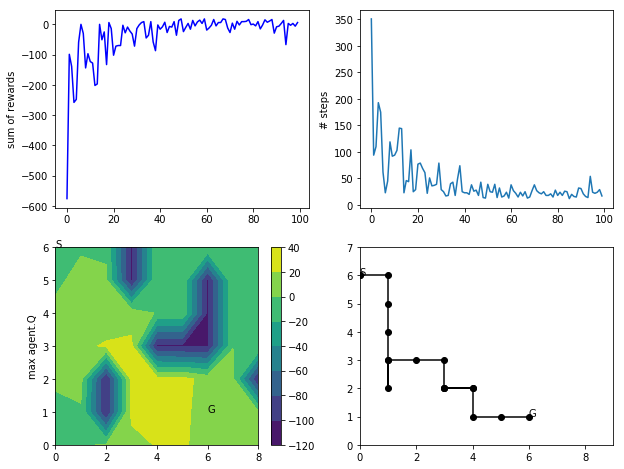

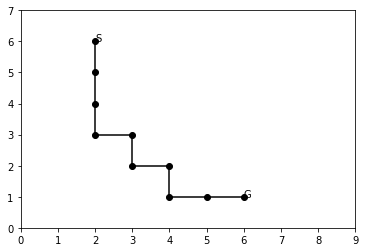

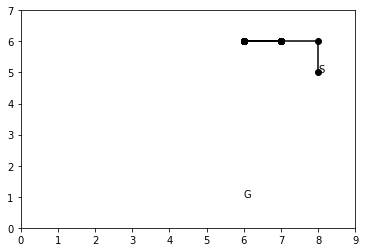

In [12]:
agent = RLAgent(env)
start = [0,0]
rtrace, steps, trace = agent.train(start, 
                                   gamma=0.99, 
                                   alpha= .1, 
                                   epsilon=0.5, 
                                   maxiter=100, 
                                   maxstep=1000)

plot_train(agent, rtrace, steps, trace, start)
plt.show()

test_start = [0,2]
test_trace = agent.test(test_start)
plot_trace(agent, test_start, test_trace)
plt.show()

test_start = [1,8]
test_trace = agent.test(test_start)
plot_trace(agent, test_start, test_trace)
plt.show();

The next change I made was to the maxiter parameter. By greatly increasing the number of iterations the agent has to learn the policy (maxiter) I allow the agent to gain more experience. I have increased maxiter from 100 to 5000 

As we can see the expected state-action values have become far more precise and the yellow area on the contour plot has been vastly increased. If we now observe the trajectory from starting position [1,8] it can now find the path to the goal node the majority of the time (a successful trajectory depends on the how well the agent learned the policy in the train() function). Although we have explored more and are finally reaching the goal from new starting locations are stability has decreased. I believe with more complex algorithms like epsilon decay the balance between exploration and exploitation might greatly improve.

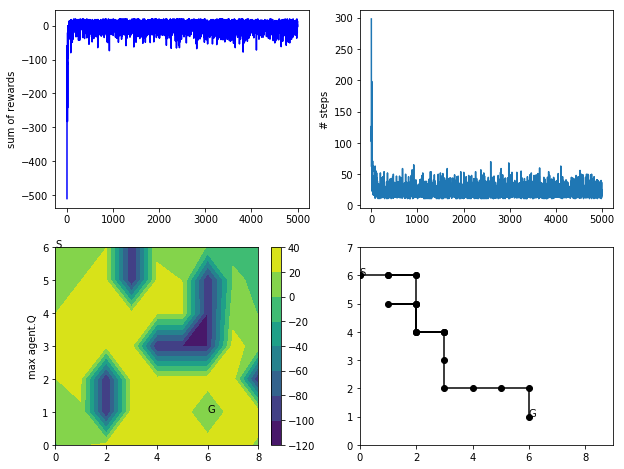

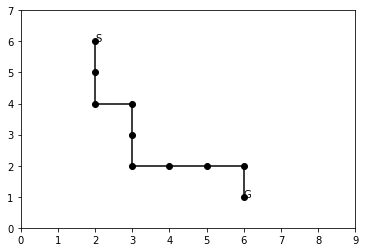

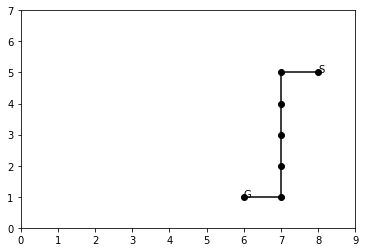

In [13]:
agent = RLAgent(env)
start = [0,0]
rtrace, steps, trace = agent.train(start, 
                                   gamma=0.99, 
                                   alpha= .1, 
                                   epsilon=0.5, 
                                   maxiter=5000, 
                                   maxstep=1000)

plot_train(agent, rtrace, steps, trace, start)
plt.show()

test_start = [0,2]
test_trace = agent.test(test_start)
plot_trace(agent, test_start, test_trace)
plt.show()

test_start = [1,8]
test_trace = agent.test(test_start)
plot_trace(agent, test_start, test_trace)
plt.show();

The last change I made to my parameters was changing the learning rate (alpha). By increasing the learning rate, the algorithm allows for a larger portion of the state-action values to be capture at one time-step. Normally with a learning rate of .1 only 10% of the TD error value only is captured per visit to a state-action pair. Now that I have increased the alpha from .1 to 1 - the whole TD error value is now captured.

As we can see in the contour plot, the expected value for each state-action pair has been vastly increased, the yellow area has greatly expanded. Most of the other plots have remained the same with slit increases to the number of steps needed and a decrease in total sum of reward per episode. Therefore, the increasing my alpha does not seem to increase the destabilization of my agent. The agent rarely seems to not find the goal node now. I believe I have achieved my goal of exploring the environment enough to find the goal when starting at drastically different start locations.

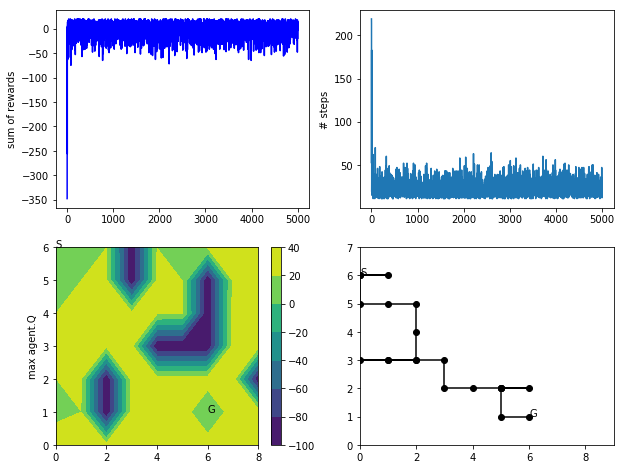

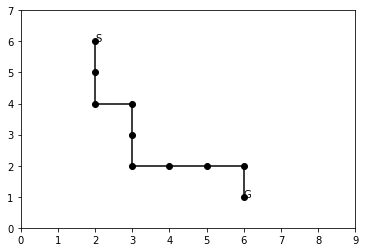

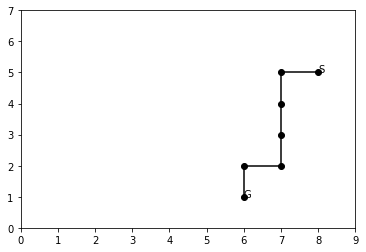

In [14]:
agent = RLAgent(env)
start = [0,0]
rtrace, steps, trace = agent.train(start, 
                                   gamma=0.99, 
                                   alpha= 1, 
                                   epsilon=0.5, 
                                   maxiter=5000, 
                                   maxstep=1000)

plot_train(agent, rtrace, steps, trace, start)
plt.show()

test_start = [0,2]
test_trace = agent.test(test_start)
plot_trace(agent, test_start, test_trace)
plt.show()

test_start = [1,8]
test_trace = agent.test(test_start)
plot_trace(agent, test_start, test_trace)
plt.show();

# V. Conclusions

Discuss the challenges or somethat that you learned. 
If you have any suggestion about the assignment, you can write about it. 

# Extra Credit

- Let us have Blackjack-V0 Tournament in class (Mar 22nd.)!
- Top 4 students will get an extra credit. 
- 2 (or more?) unique training attemps will also get an extra credit. (Sales for it to be considered.) 

## Grading

We will test your notebook with an additional grid.txt file. Please make sure to test in different maze input files. 

points | | description
--|--|:--
5 | Overview| states the objective and the appraoch 
10 | Maze Problem | 
 | 5| Includes description of maze problem
 | 5| Explains the GridWorld
10 | Blackjack
 | 5| Includes description of maze problem
 | 5| Explains the Backjack-V0 (OpenAI Gym)
25 | Methods | 
 | 5| Review of the SARSA and Q-Learning
 | 5| Choice of TD learning and Reason
 |10| Implementation of the selected approach
 | 5| explanation of the codes
45 | Results 
| 5| Reports the selected parameters for both problems. 
|20| Experimental outputs that show the choice of parameters. How do you choose them? (10 points per each problem)
|10| Output plots (5 for each)
|10| reading and analysis of learning results and plots (5 for each)
5 | Conclusions 
